# DIVI Intensivregister

## What are we dealing with?
It's a php-generated page containing a table which lists many (not all?) German clinics in a column labeled `Klinikname`. Other columns are labeled *Kontakt* = contact info, *Bundesland* = federal state, [*ICU*](https://en.wikipedia.org/wiki/Intensive_care_unit) *low care*, *ICU high care*, [*ECMO*](https://en.wikipedia.org/wiki/Extracorporeal_membrane_oxygenation) and *Stand* = time stamp. The columns *ICU* and *ECMO* solely contain colored bubbles to illustrate the availability of these resources. The legends explains as follows:

* red = *Verfügbar* = ready
* yellow = *Begrenzt* = limited
* green = *Ausgelastet* = exhausted
* unavailable = unknown state

A form offers sorting and filtering of that table.

## What to contribute?
The table only shows contemporary data as clinics submit their data (time stamp!). Aside to some statistics on that data -- what might be interesting to see is how it develops over time during the [COVID19](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic) pandemic.

# Approach

## Fetch data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scrape import scrape, divi
plt.style.use('ggplot')

In [19]:
scrape_result = divi.to_dataframe(mapping=lambda x: x)
scrape_result

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Ortenau Klinikum Wolfach,Website,BW,green,green,unavailable,2020-04-01 19:49:00
1,Ortenau Klinikum Kehl,Website,BW,red,green,unavailable,2020-04-01 19:45:00
2,Ortenau Klinikum Offenburg St. Josefsklinik,Website,BW,red,red,unavailable,2020-04-01 19:43:00
3,Ortenau Klinikum Offenburg Ebertplatz,Website,BW,green,green,unavailable,2020-04-01 19:27:00
4,Ortenau Klinikum Lahr-Ettenheim Standort Lahr,Website,BW,green,green,unavailable,2020-04-01 19:46:00
...,...,...,...,...,...,...,...
955,Universitätsklinikum Bonn,Operative Intensivmedizin Website,NRW,green,green,green,2020-03-30 08:28:00
956,Klinikum Nürnberg,Website,BY,green,green,green,2013-03-20 09:26:00
957,Helios Klinikum Bad Saarow,"ITS 1, ITS 2, ITS 3 Website",BB,red,green,green,2020-04-01 06:55:00
958,Elisabeth-Krankenhaus Essen,kardiologisch- internistische Intensivstation ...,NRW,green,green,green,2020-04-01 15:52:00


In [20]:
scrape_result.describe()

,Klinikname,Kontakt,Bundesland,ICU low care,ICU high care,ECMO,Stand
count,960,960,960,960,960,960,960
unique,939,386,16,3,3,4,712
top,Krankenhaus Tauberbischofsheim,Intensivstation Website,NRW,green,green,unavailable,2020-04-01 08:49:00
freq,2,177,215,706,756,751,7
first,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-20 09:26:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-01 19:49:00


Apparently, *St. Marienhospital Vechta gGmbH* has got a double entry.

## Raw data
Next, let's deduplicate and drop the contact info. Additionally, say the colors describe some kind of stress signal, turn colors into float values (red being high and green being low):

|  color        |  float  |
|:--------------|:-------:|
|  red          |   0.0   |
|  yellow       |   0.5   |
|  green        |   1.0   |
|  unavailable  |   NAN   |

In [21]:
df = scrape_result \
.drop_duplicates() \
.drop('Kontakt', axis=1) \
.replace({'green': 0.0, 'yellow': 0.5, 'red': 1.0, 'unavailable': np.nan})
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,Ortenau Klinikum Wolfach,BW,0.0,0.0,NaN,2020-04-01 19:49:00
1,Ortenau Klinikum Kehl,BW,1.0,0.0,NaN,2020-04-01 19:45:00
2,Ortenau Klinikum Offenburg St. Josefsklinik,BW,1.0,1.0,NaN,2020-04-01 19:43:00
3,Ortenau Klinikum Offenburg Ebertplatz,BW,0.0,0.0,NaN,2020-04-01 19:27:00
4,Ortenau Klinikum Lahr-Ettenheim Standort Lahr,BW,0.0,0.0,NaN,2020-04-01 19:46:00
...,...,...,...,...,...,...
955,Universitätsklinikum Bonn,NRW,0.0,0.0,0.0,2020-03-30 08:28:00
956,Klinikum Nürnberg,BY,0.0,0.0,0.0,2013-03-20 09:26:00
957,Helios Klinikum Bad Saarow,BB,1.0,0.0,0.0,2020-04-01 06:55:00
958,Elisabeth-Krankenhaus Essen,NRW,0.0,0.0,0.0,2020-04-01 15:52:00


In [22]:
df.describe()

,ICU low care,ICU high care,ECMO
count,960.000000,960.000000,209.000000
mean,0.186979,0.141146,0.239234
std,0.336651,0.292636,0.380019
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.500000,0.000000,0.500000
max,1.000000,1.000000,1.000000


## Cleanup
How does the data contribution spread over time?

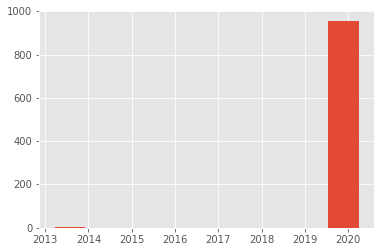

In [23]:
df.describe()
df['Stand'].hist()

Clean this up a bit: remove pre 19/20 contributions.

(array([737501., 737503., 737505., 737507., 737509., 737511., 737513.,
        737515., 737516.]),
 <a list of 9 Text major ticklabel objects>)

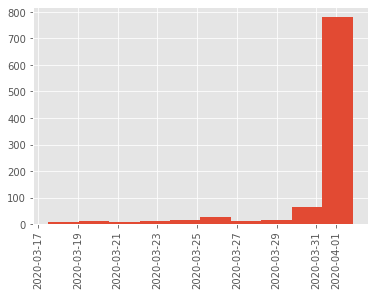

In [24]:
from datetime import datetime
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())]
df['Stand'].hist()
plt.xticks(rotation=90)

Better! Most contributions have been made recently, that's good.

## Plot average values (per federal state)

Text(0, 0.5, 'federal state')

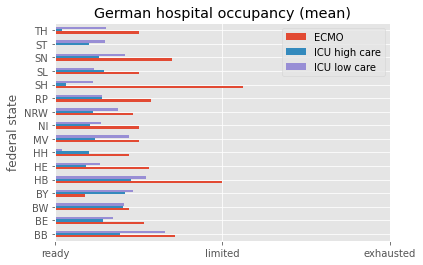

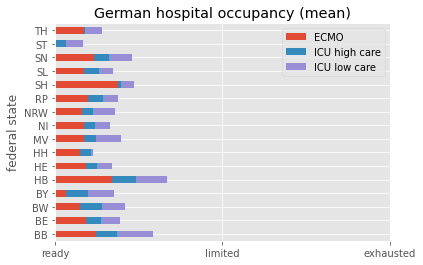

In [25]:
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=False)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
plt.ylabel("federal state")
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 1.5, 3.0],["ready", "limited", "exhausted"]) # 3x[0..1] = [0..3]
plt.ylabel("federal state")

So much for contemporary data.

# Historic data
Instead of downloading the data from DIVI we are going to use the old scrapes in `data/divi.tsv`:

In [70]:
#!git pull 2&>1 >/dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scrape import scrape, divi
df = pd \
.read_csv("data/divi.tsv", sep="\t", index_col=0, parse_dates=True) \
.drop_duplicates() \
.drop('Kontakt', axis=1)
df['Stand'] = pd.to_datetime(df['Stand'])
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())]
df

,Klinikname,Bundesland,ICU low care,ICU high care,ECMO,Stand
0,"Ruhrlandklinik, Westdeutsches Lungenzentrum am...",NRW,1.0,1.0,NaN,2020-04-02 17:37:00
1,SRH Kurpfalzkrankenhaus GmbH,BW,0.0,0.0,NaN,2020-04-02 17:41:00
2,Uniklinikum Münster- Marienhospital Steinfurt,NRW,0.5,1.0,NaN,2020-04-02 17:34:00
3,Ev. Krankenhaus BETHESDA zu Duisburg GmbH,NRW,1.0,1.0,NaN,2020-04-02 17:30:00
4,St. Mauritius Therapieklinik,NRW,0.0,0.0,NaN,2020-04-02 17:16:00
...,...,...,...,...,...,...
7501,Universitätsklinikum Dresden,SN,1.0,1.0,1.0,2020-03-24 14:25:00
7502,Universitätsklinikum Erlangen,BY,1.0,1.0,1.0,2020-03-24 08:27:00
7503,Universitätsklinikum Bonn,NRW,1.0,1.0,1.0,2020-03-22 15:55:00
7504,Helios Klinikum Bad Saarow,BB,0.5,1.0,1.0,2020-03-24 07:15:00


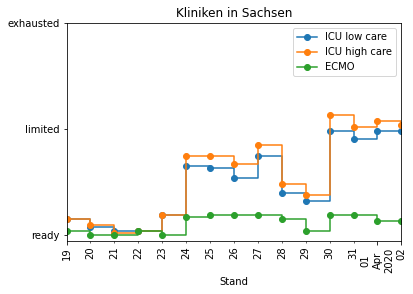

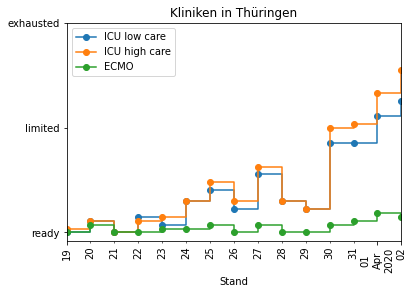

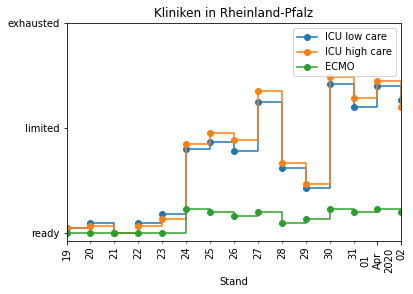

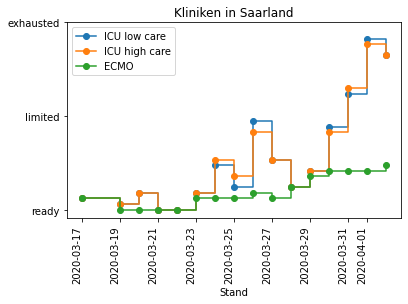

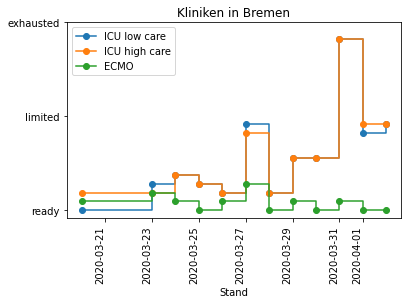

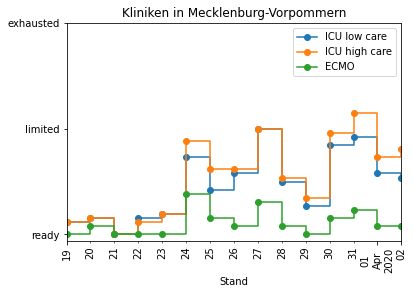

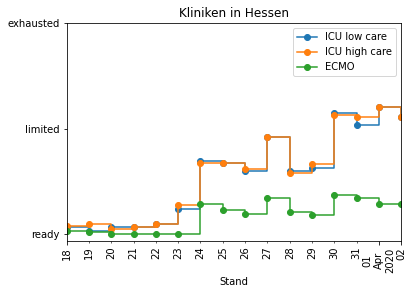

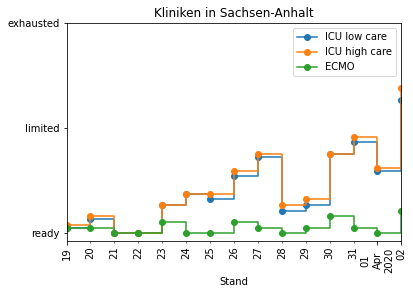

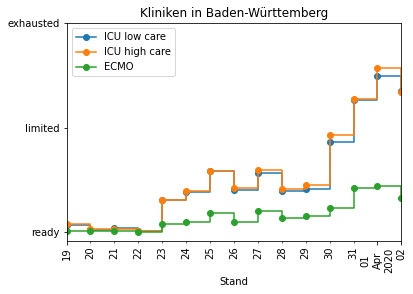

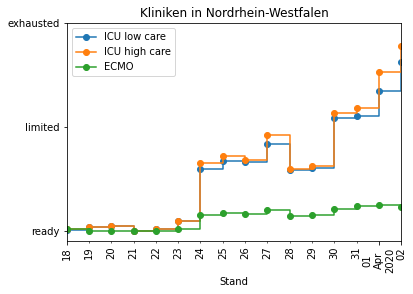

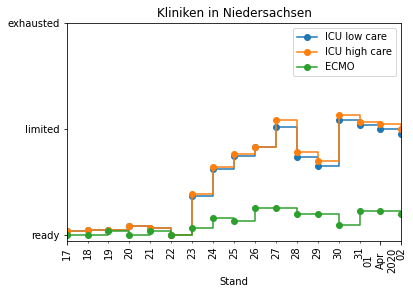

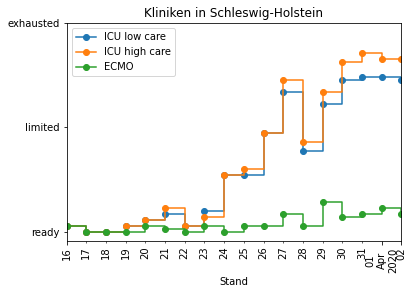

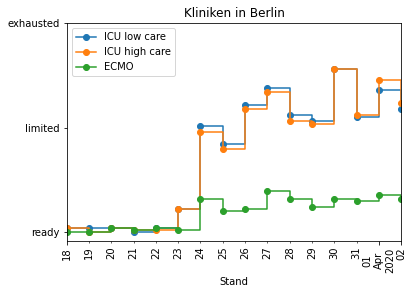

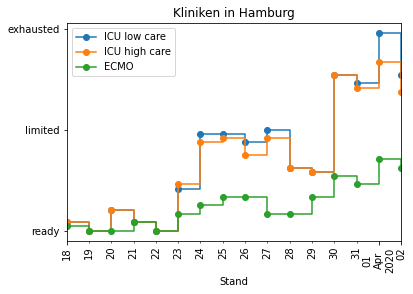

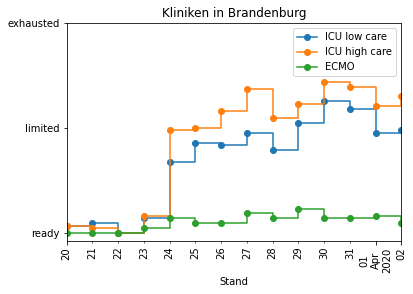

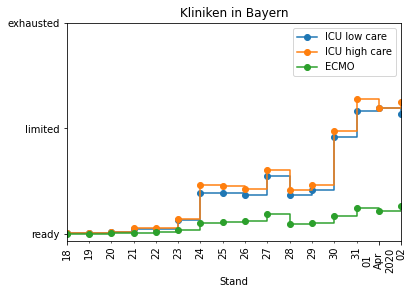

In [111]:
import matplotlib.dates as mdates

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NRW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
}

columns = ['ICU low care', 'ICU high care', 'ECMO']
federal_states = list(set(df['Bundesland']))
exhaustion = dict()

# plot each bundesland's total exhaustion
# but also keep each curve in dict bundesland_curves for later correlations
for federal_state in federal_states:
    if federal_state == "0":
        continue
        
    clinics_curves_sum = None
    federal_state_clinics = list(set(df[df['Bundesland'] == federal_state]['Klinikname']))
    
    # One clinic enters "0" as their bundesland but is actually situated in NRW
    if federal_state == "NRW":
        appendix = list(set(df[df['Bundesland'] == "0"]['Klinikname']))
        federal_state_clinics = list(set(federal_state_clinics + appendix))
    
    # apply padding to each clinic's curve
    for clinic in federal_state_clinics:
        # use resample() here because we want to correlate day-by-day later
        clinic_curve = df[df['Klinikname'] == clinic] \
        .set_index('Stand') \
        .drop(columns=['Bundesland', 'Klinikname']) \
        .resample("1D").sum() \
        .fillna(method="pad")
        # TODO .cumsum() useful here?

        # is there something less clumsy from pandas?
        if clinics_curves_sum is None:
            clinics_curves_sum = clinic_curve
        else:
            clinics_curves_sum = clinics_curves_sum.add(clinic_curve, fill_value=0)
    
    exhaustion[federal_state] = clinics_curves_sum
    clinics_curves_sum.plot(kind='line', drawstyle="steps-post", y=columns, marker='o', rot=90)
    
    num_clinics = len(federal_state_clinics)
    plt.yticks([0.0 * num_clinics, 0.5 * num_clinics, 1.0 * num_clinics],
               ["ready", "limited", "exhausted"])
    plt.title("Kliniken in %s" % federal_state_translation[federal_state])

In [112]:
from time import sleep
from scrape import entorb
for bundesland in bundeslands:
    try:
        sleep(200)
        cases = entorb.to_dataframe(bundesland)
        cases.plot()
        plt.title("Fälle in %s" % bundesland_translate[bundesland])
    except Exception as e:
        print(bundesland, repr(e))

SN <HTTPError 404: 'Not Found'>
TH <HTTPError 404: 'Not Found'>


KeyboardInterrupt: 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'RKI-Zählung für Sachsen')

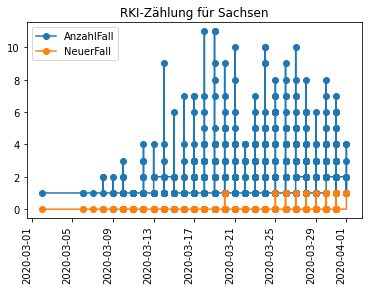

In [131]:
%load_ext autoreload
%autoreload 2
from scrape import rki
federal_state = 'SN'
rki.to_dataframe(federal_state, cumulated=False) \
.plot(kind='line', drawstyle="steps-post", marker='o', rot=90)
plt.title("RKI-Zählung für %s" % federal_state_translation[federal_state])